In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import json
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter
from tqdm.auto import tqdm, trange
from collections import defaultdict, namedtuple, Counter

# Dataset exploration

In [2]:
def read_json(file):
    with open(file, 'r', encoding='utf-8') as f:
        return json.loads(f.read())

Читаю датасет:

In [3]:
dataset_path = r"C:\Users\Igor\IdeaProjects\ide-plugin\build\idea-sandbox\system\dataset\java-small"
stats_path = r"C:\Users\Igor\IdeaProjects\ide-plugin\build\idea-sandbox\system\dataset\java-small"

In [4]:
def read_files(path, postfix='_dataset.json'):
    files = list(filter(lambda p: os.path.isfile(p) and p.endswith(postfix), 
                        map(lambda f: os.path.join(path, f), os.listdir(path))
                       ))
    return {os.path.relpath(file, path).replace(postfix, ""): read_json(file) for file in files}

dataset = read_files(dataset_path)

In [5]:
dataset.keys()

dict_keys(['cassandra-dtest-shaded', 'elasticsearch', 'gdx-parent', 'gradle', 'hadoop', 'hibernate-orm', 'intellij-community', 'liferay-portal', 'presto-root', 'spring', 'wildfly-parent'])

In [6]:
file_stats = read_files(stats_path, postfix='_stats.json')
file_stats = {k: list(v.values()) for k, v in file_stats.items()}

In [7]:
DatasetStats = namedtuple("DatasetStats", ["variable_stats", "usage_counts", "file_var_counts", "file_lengths"])
def collect_stats(dataset):
    variable_stats = []
    usage_counts = []
    file_var_counts = []
    for file_vars in dataset.values():
        file_var_counts.append(len(file_vars))
        for var in file_vars:
            variable_stats.append(var['psiInterface'])
            usage_counts.append(len(var['ngrams']))
    return variable_stats, usage_counts, file_var_counts

dataset_stats = {k: DatasetStats(*collect_stats(dataset[k]), file_stats[k]) for k in dataset.keys()}

## Количество полей, параметров и локальных переменных

In [8]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (14, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [9]:
def plot_counts(ax, x_labels, categories, data):
    permutation = np.argsort(data.sum(axis=1))[::-1]
    data = data[permutation, :]
    x_labels = x_labels[permutation]
    length = len(x_labels)
    n_categories = len(categories)
    width = 0.15 # width of bar
    x = np.arange(length)
    cmap = plt.cm.get_cmap('CMRmap', n_categories + 1)
    for i, l in enumerate(categories):
        ax.bar(x + (i * width), data[:, i], width, color=cmap(i), label=l)

    ax.set_ylabel('Interface count')
#     ax.set_ylim(0, 10e4)
#     ax.set_yscale('log')
    ax.set_xticks(x + width * (n_categories / 2. - 0.5))
    ax.set_xticklabels(x_labels, rotation=85)
    ax.set_xlabel('Dataset name')
    ax.set_title('Number of interfaces')
    ax.legend()
    ax.grid(True, 'major', 'y', ls='--', lw=1, c='k', alpha=.3)
    
def plot_densities(ax, x_labels, category_names, data):
    n_categories = len(category_names)
    data_density = data / np.sum(data, axis=1, keepdims=True)
    
    permutation = np.argsort(data_density[:, 0])[::-1]
    data_density = data_density[permutation, :]
    x_labels = x_labels[permutation]
    x_labels = np.append(x_labels, ['mean'])
    
    data_density = np.concatenate((data_density, data_density.mean(axis=0).reshape(1, -1)), axis=0)
    
    data_cum = data_density.cumsum(axis=1)
    cmap = plt.cm.get_cmap('CMRmap', n_categories + 1)
    category_colors = cmap(np.arange(n_categories))
    
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data_density, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data_density[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(x_labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r < 0.6 else 'black'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, f"{int(c * 100)}%", ha='center', va='center',
                    color=text_color, fontsize='large')
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, -0.07),
              loc='lower left', fontsize='large')
    ax.set_title('Densities of interfaces')

In [10]:
def explore_var_interfaces(dataset_stats):
    length = len(dataset_stats)
    x_labels = np.array(list(dataset_stats.keys()))
    labels = ['PsiField', 'PsiParameter', 'PsiLocalVariable']#, 'PsiEnumConstant', 'PsiResourceVariable']
    
    n_labels = len(labels)
    data = np.empty((length, n_labels))
    for i, d in enumerate(x_labels):
        counter = Counter(dataset_stats[d].variable_stats)
        data[i] = [counter[l] if l in counter else 0 for l in labels]

    # Set plot parameters
    fig, ax = plt.subplots(figsize=(14, 18), nrows=2)
    plot_counts(ax[0], x_labels, labels, data)
    plot_densities(ax[1], x_labels, labels, data)
    fig.tight_layout()
    plt.show()

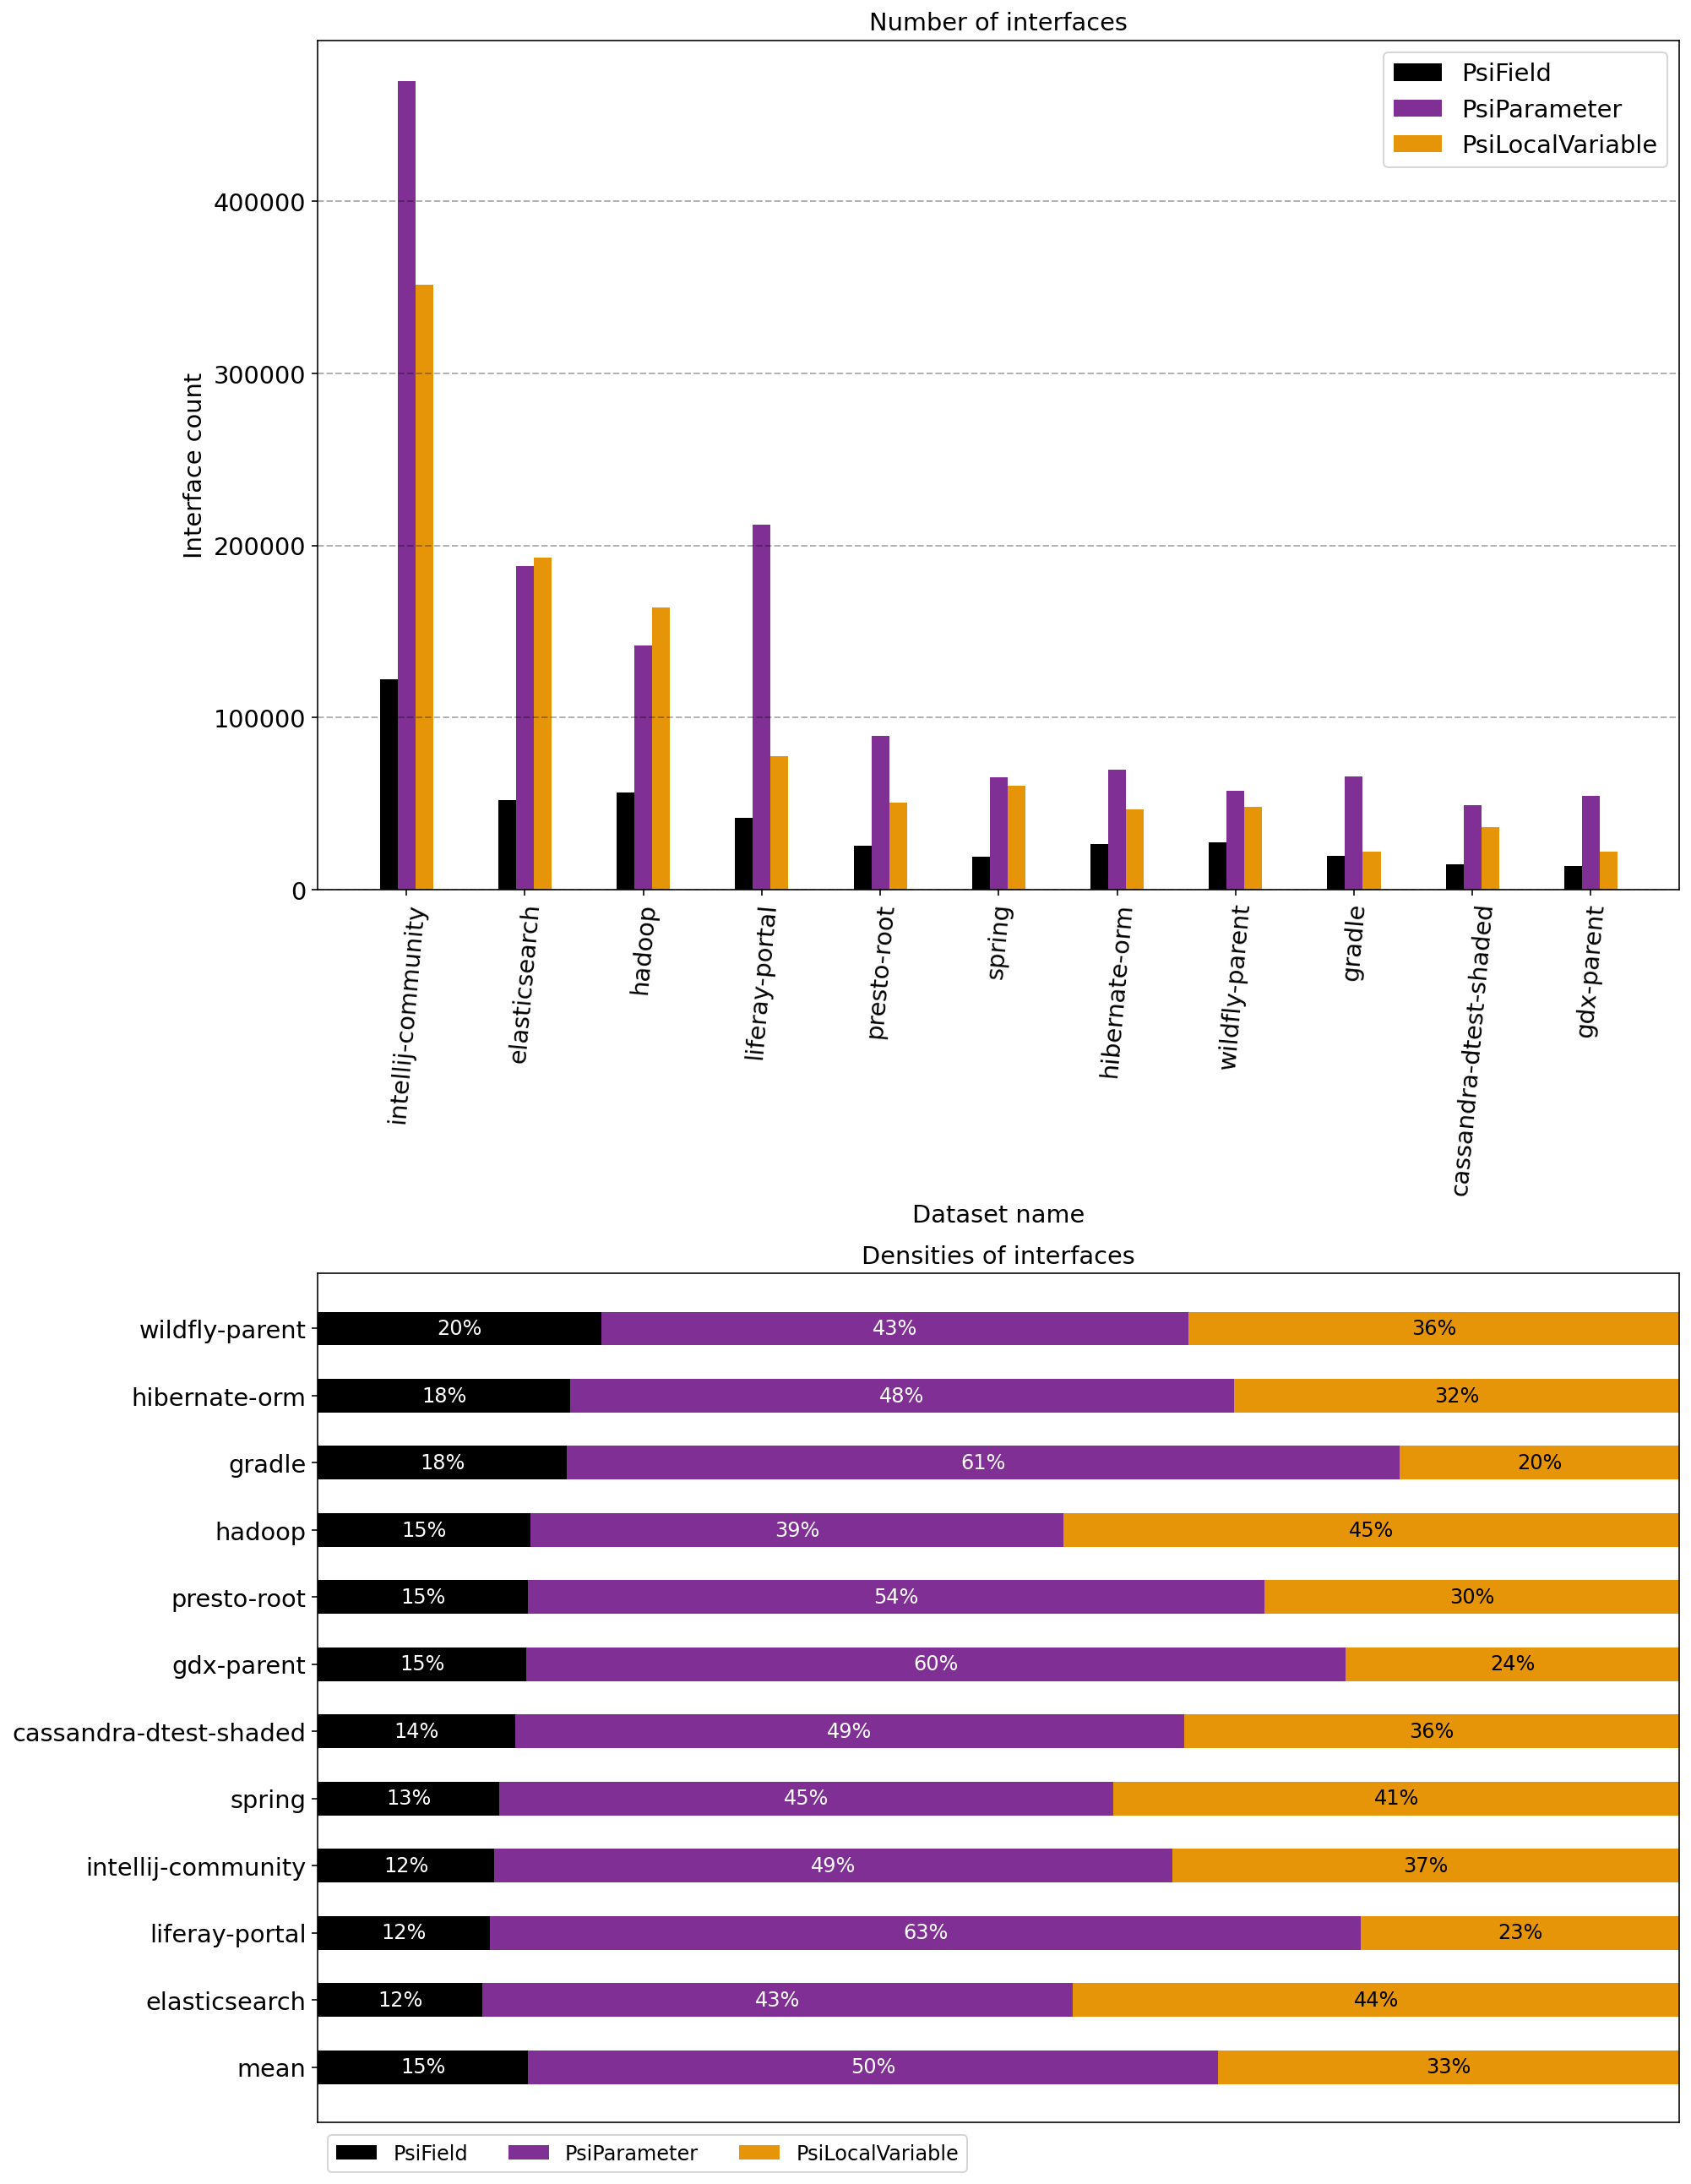

In [11]:
explore_var_interfaces(dataset_stats)

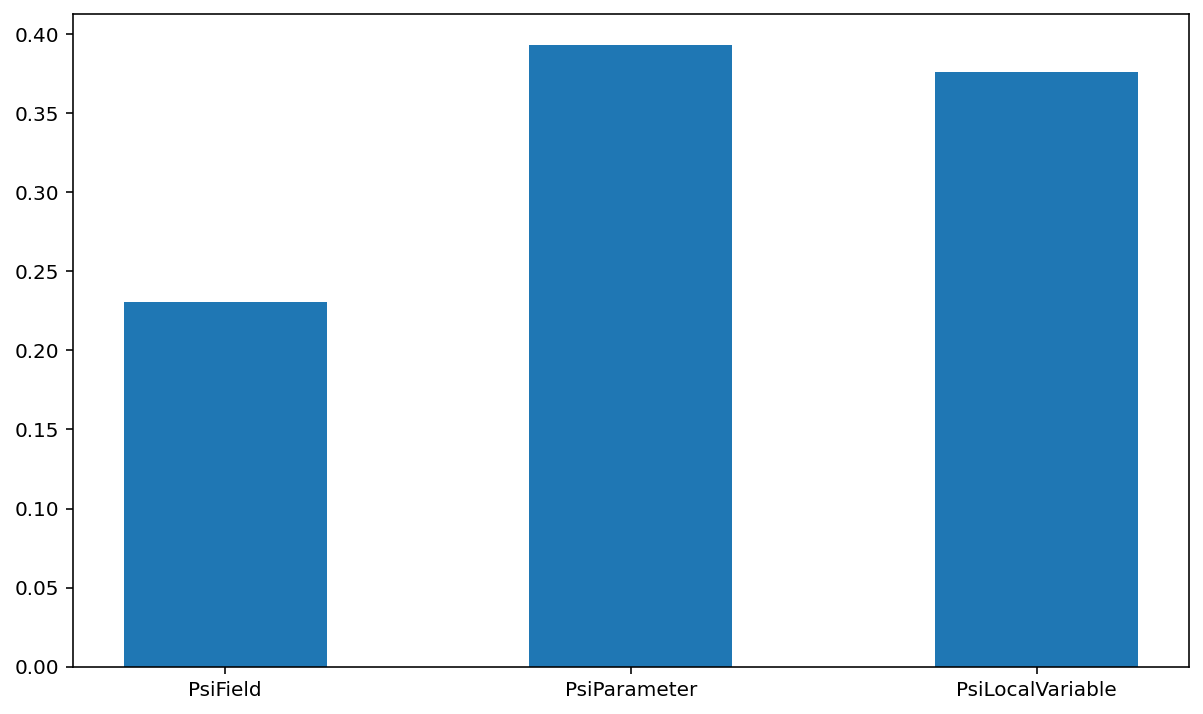

In [83]:
# plt.subplots(figsize=(10, 6))
# plt.hist(variable_stats, bins=3, range=(0,3), rwidth=0.5, align='left', density=True)
# plt.show()

## Распределение количества использований у переменной

In [85]:
def explore_usage_numbers(dataset_stats, **kwargs):
    length = len(dataset_stats) + 1
    fig, ax = plt.subplots(figsize=(14, 2 * length), nrows=length // 2, ncols=2)
    ax = ax.reshape(-1)
    fig.suptitle("Distribution of usage counts", fontsize='x-large', y=0.99)
    
    plot_mean_distribution = 'range' in kwargs and kwargs['range'] is not None
    all_counts = 0
    for i, (k, v) in enumerate(dataset_stats.items()):
        usage_counts = v.usage_counts
        counts, x, _ = ax[i].hist(usage_counts, **kwargs)
        if plot_mean_distribution: all_counts += counts
        if len(x) < 25: ax[i].set_xticks(x)
        ax[i].set_ylabel('Density')
        ax[i].set_xlabel('Number of var usages')
        ax[i].set_title(f'{k}')
    if length % 2 == 0: ax[-1].set_visible(False)
    fig.tight_layout()
    plt.show()
    
    if plot_mean_distribution:
        fig, ax = plt.subplots(figsize=(14, 4))
        x = list(x[:-1])
        ax.bar(x, all_counts / all_counts.sum())
        if len(x) < 50: ax.set_xticks(x)
        ax.set_ylabel('Density')
        ax.set_xlabel('Number of var usages')
        ax.set_title('Mean distribution')
        plt.show()

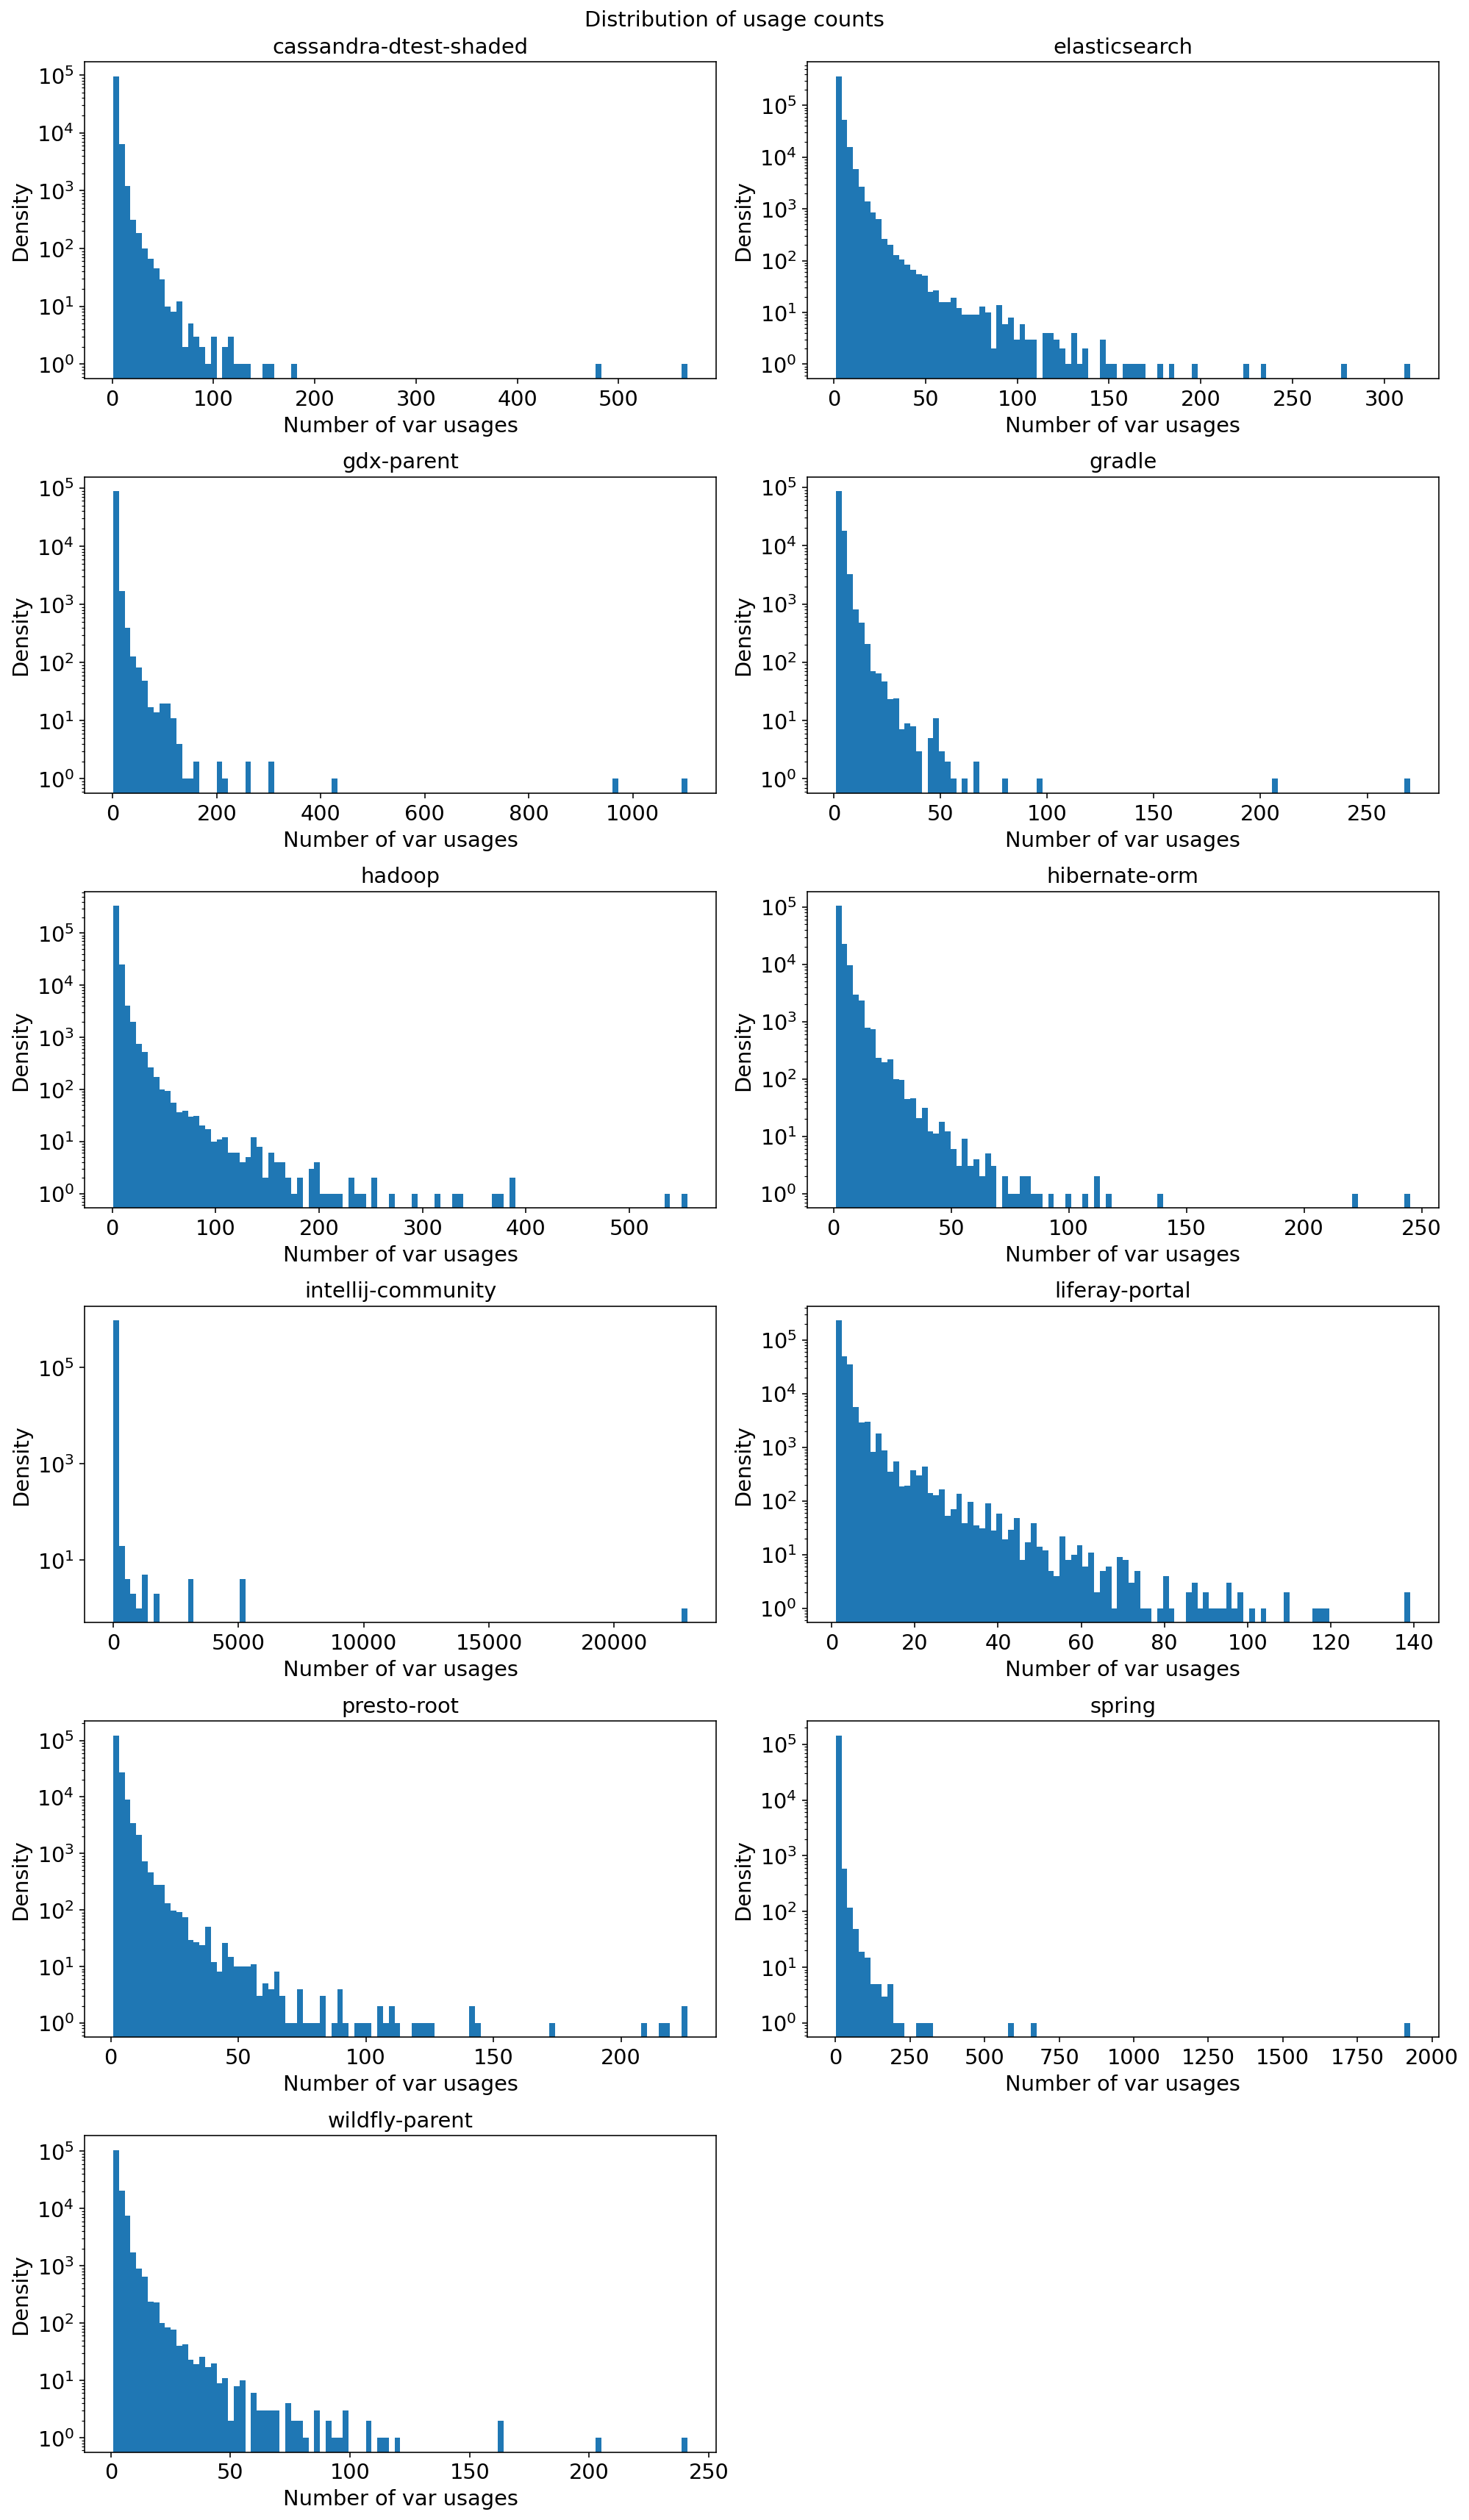

In [87]:
explore_usage_numbers(dataset_stats, bins=100, range=None, log=True)

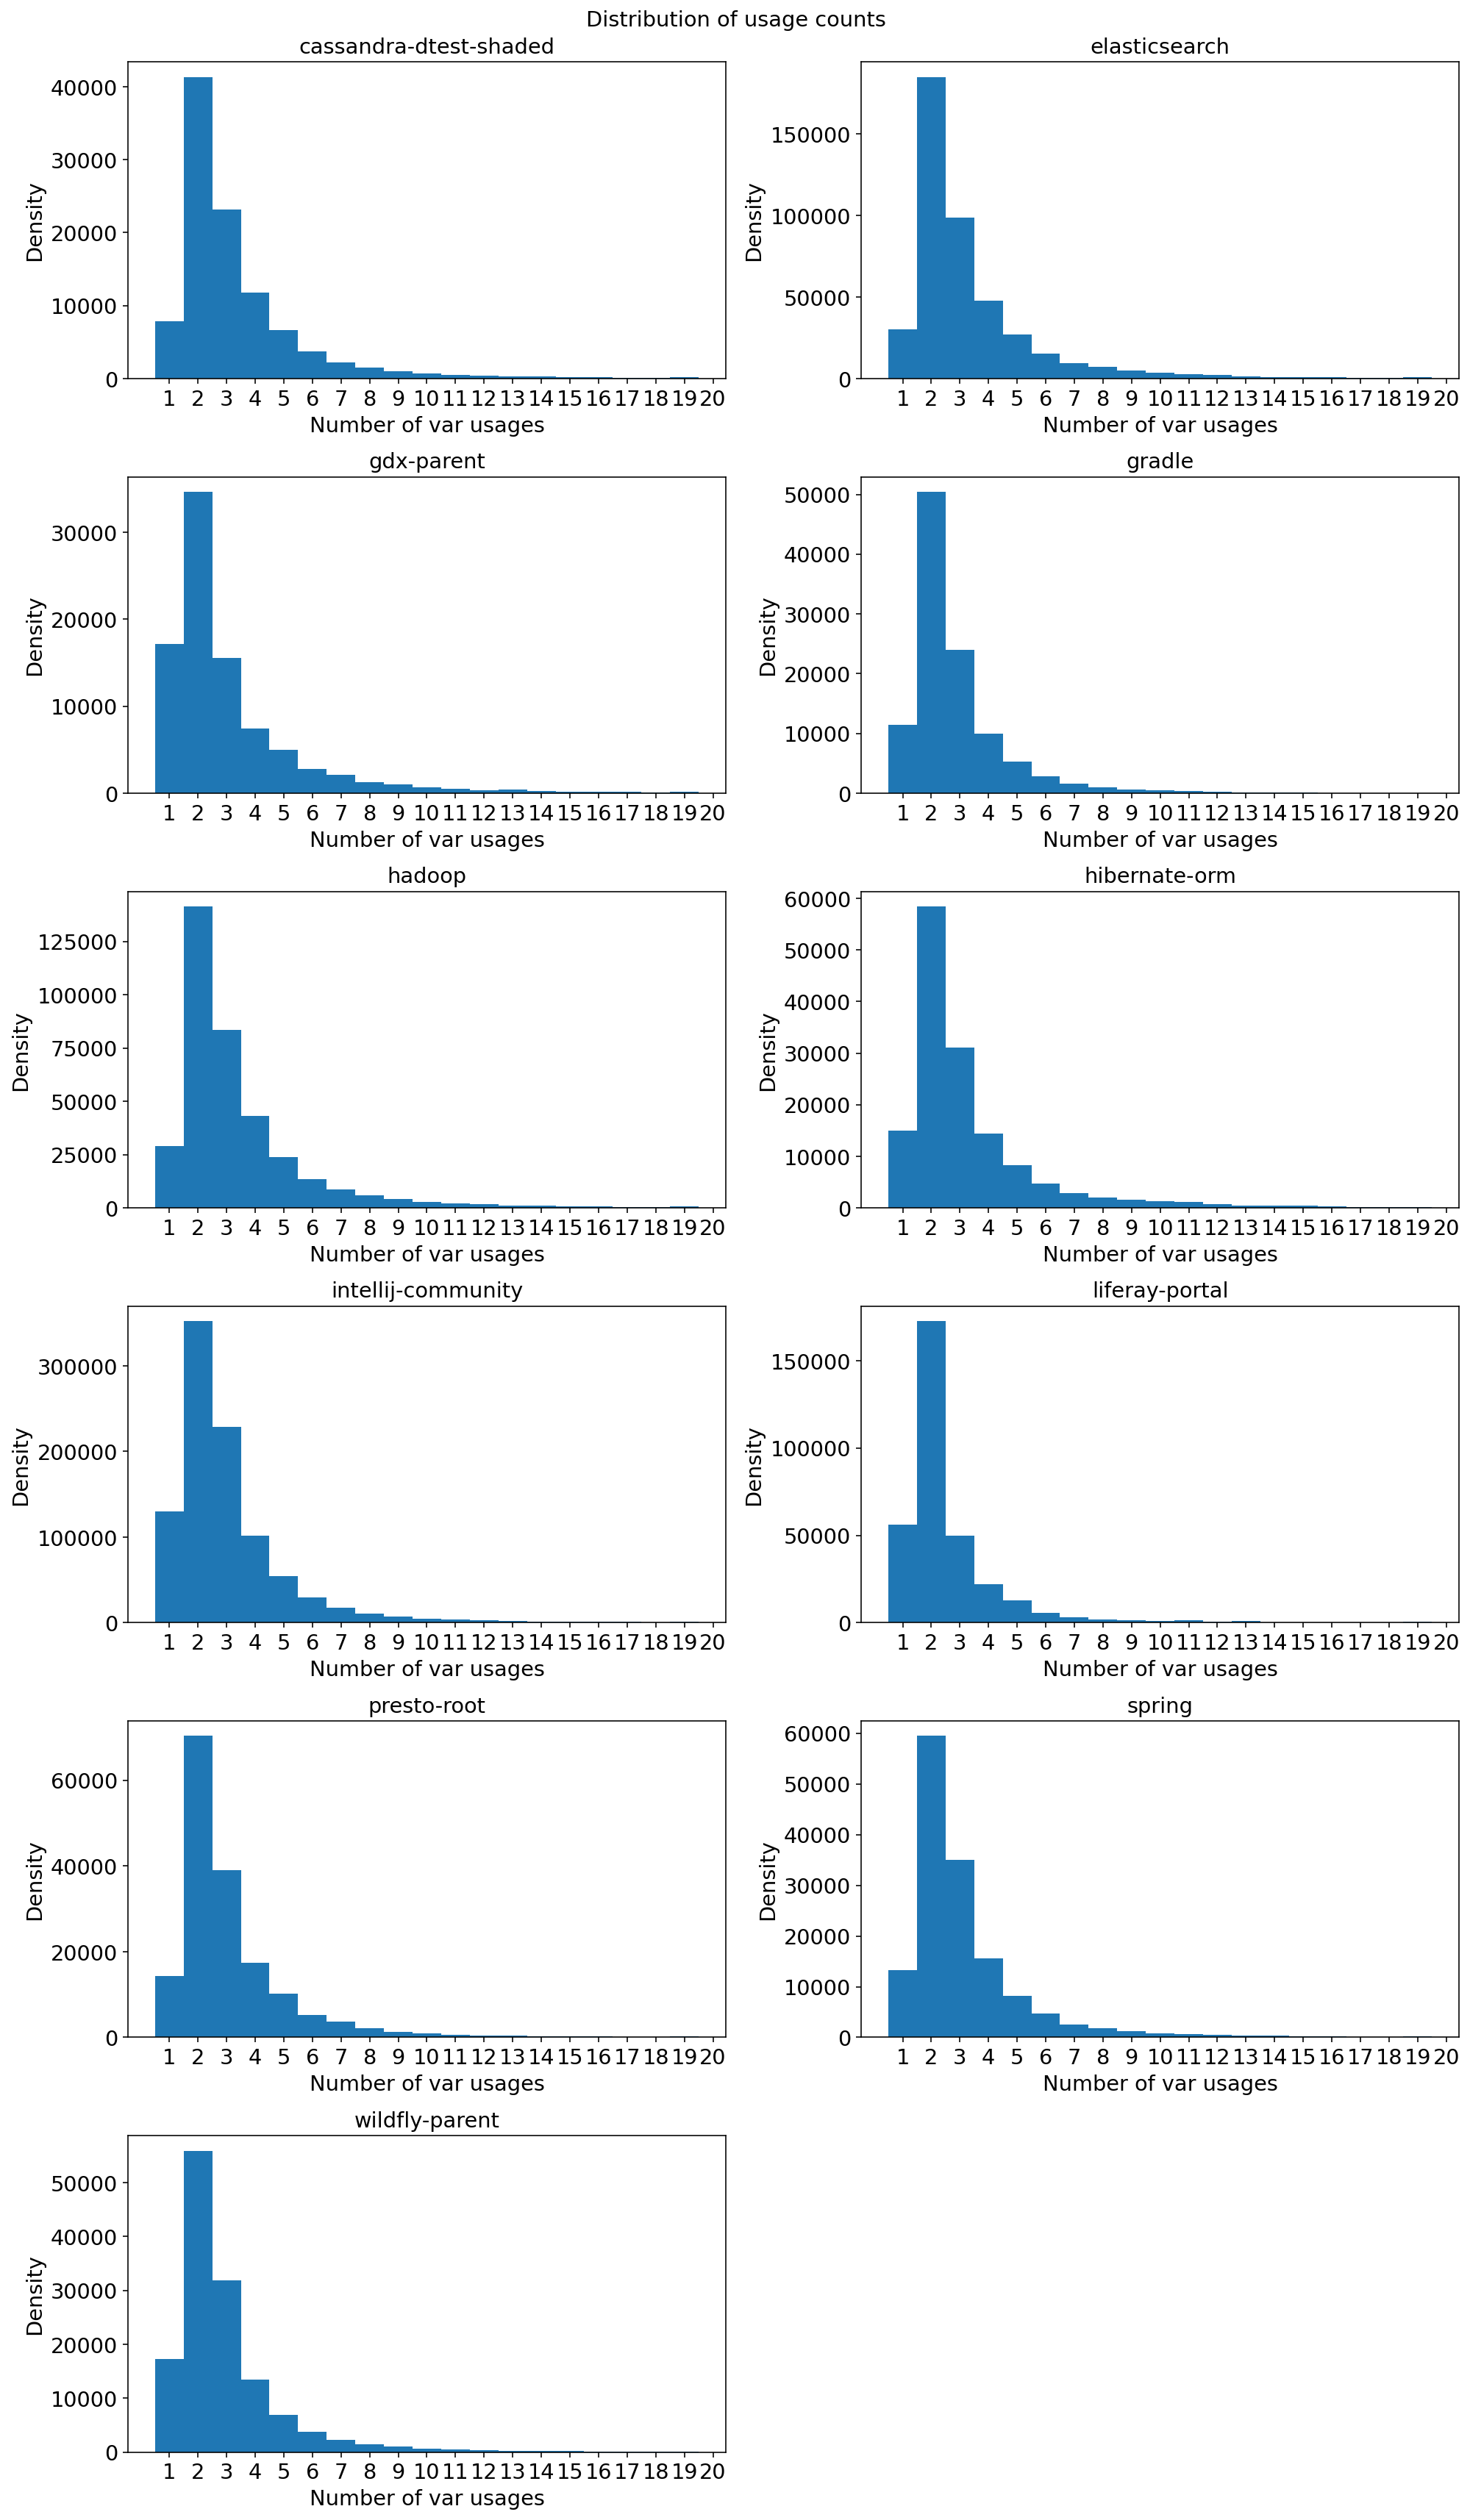

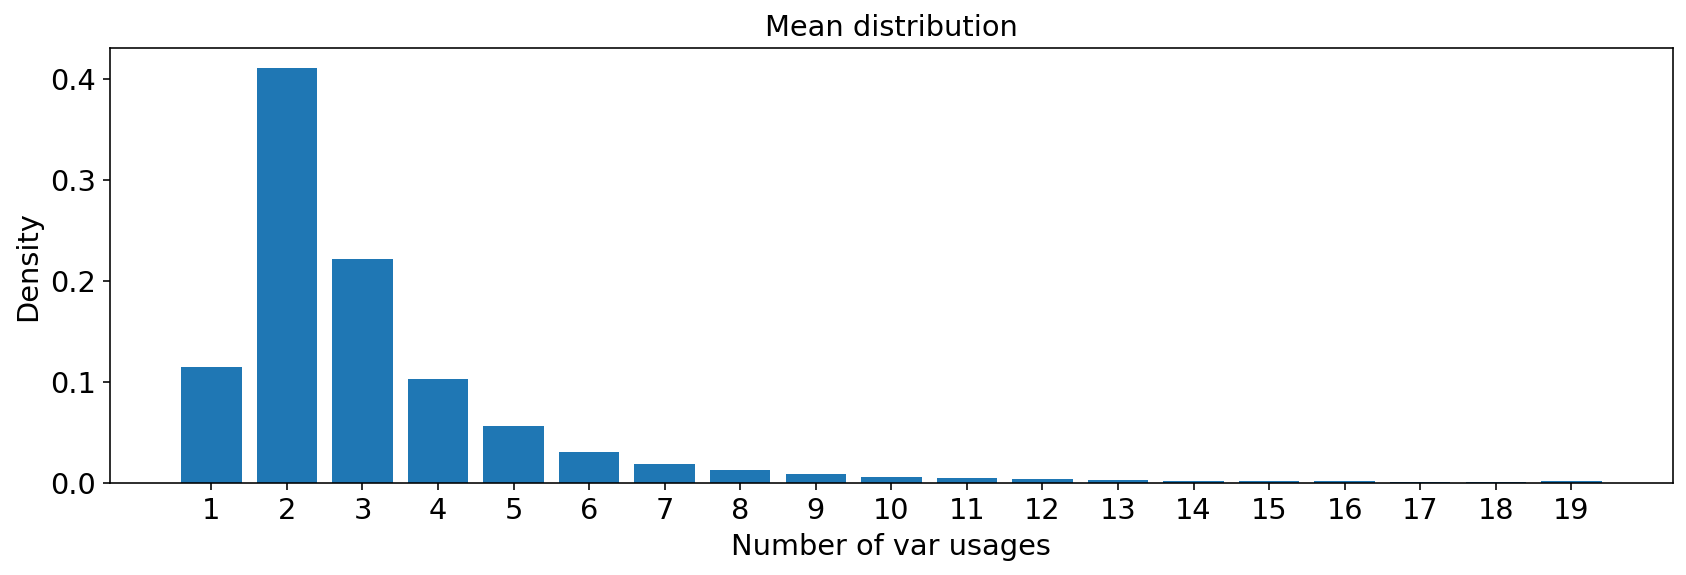

In [88]:
explore_usage_numbers(dataset_stats, bins=19, range=(1, 20), align='left')

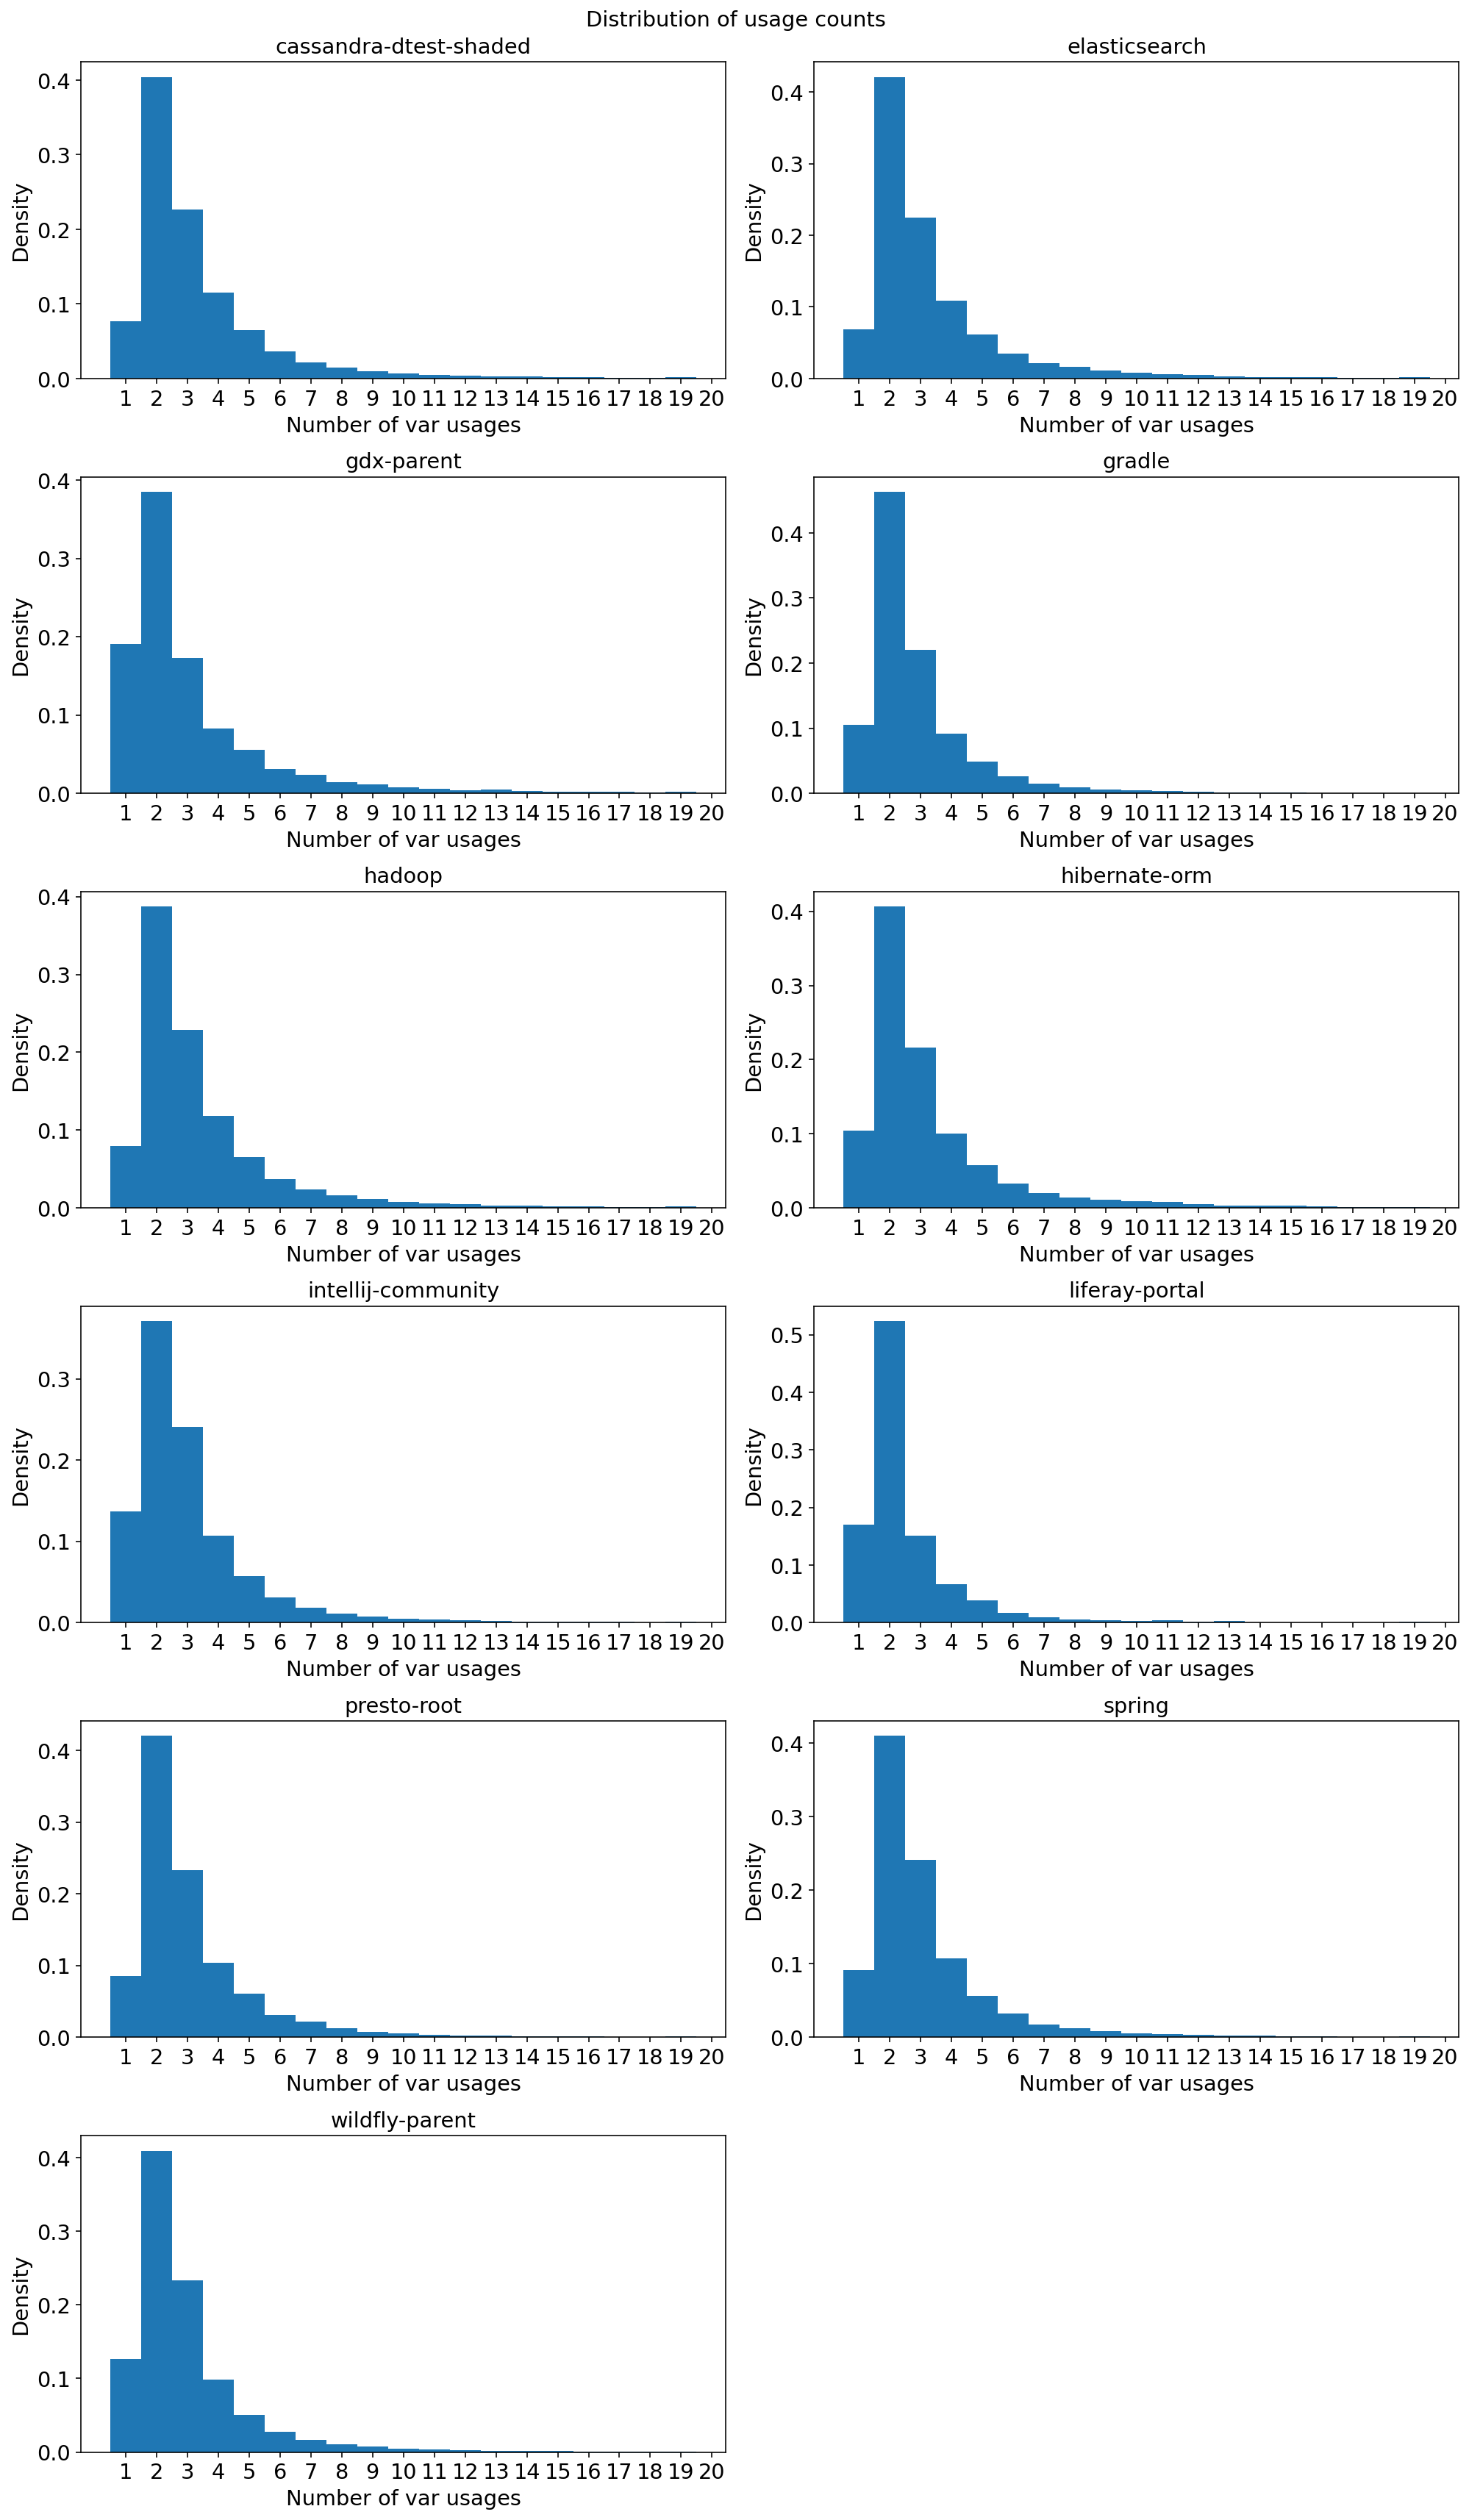

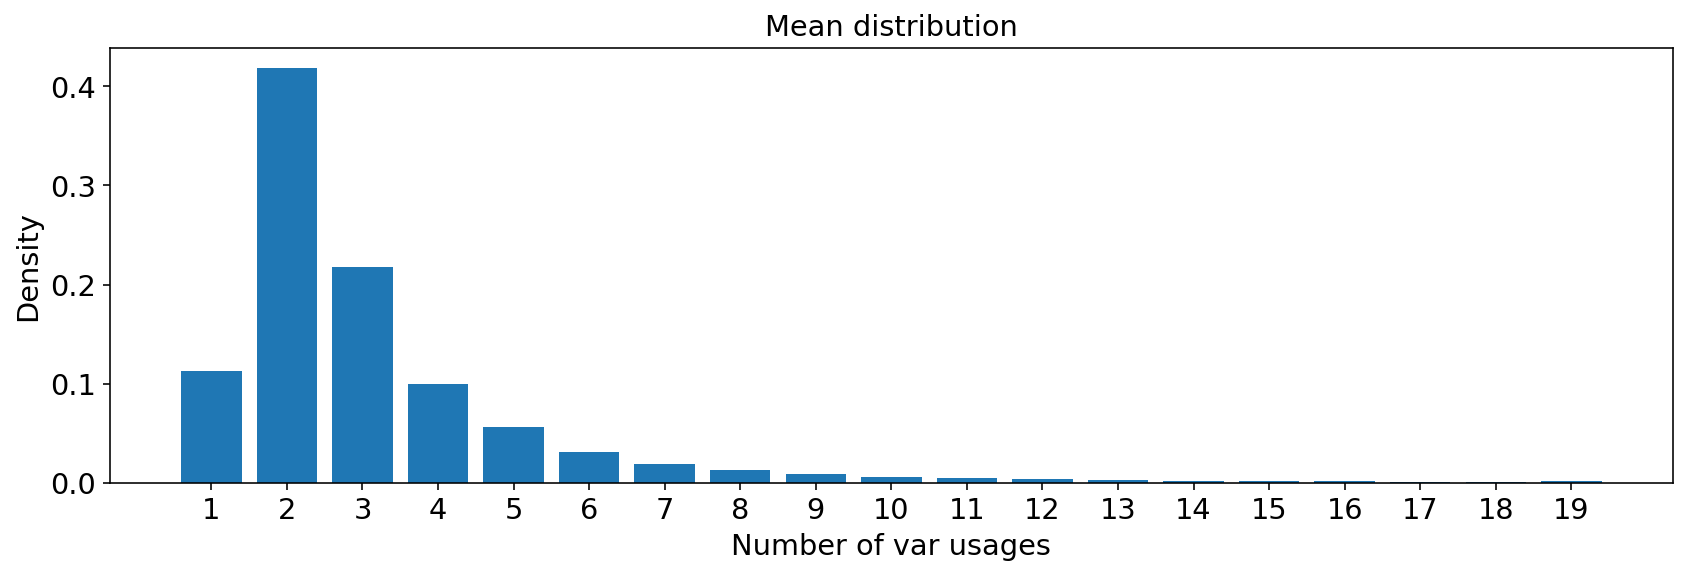

In [89]:
explore_usage_numbers(dataset_stats, bins=19, range=(1, 20), align='left', density=True)